# Experiments with relation extraction

For the Filter Bubble project

## 1. Roberta Named Entity Recogntion by Erik Novak

Source: https://www.kaggle.com/eriknovak/pytorch-roberta-named-entity-recognition

In [1]:
# visualization libraries
import matplotlib.pyplot as plt
import numpy as np
import re

# pytorch libraries
import torch # the main pytorch library
import torch.nn as nn # the sub-library containing Softmax, Module and other useful functions
import torch.optim as optim # the sub-library containing the common optimizers (SGD, Adam, etc.)

# huggingface's transformers library
from transformers import RobertaForTokenClassification, RobertaTokenizer

# huggingface's datasets library
from datasets import load_dataset, Dataset, DatasetDict, Features, Value
from datasets.features import Sequence, ClassLabel

# the tqdm library used to show the iteration progress
import tqdm
tqdmn = tqdm.notebook.tqdm

In [2]:
roberta_version = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(roberta_version)

In [3]:
dataset = load_dataset("conll2003")

Reusing dataset conll2003 (/home/erikt/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


In [4]:
def read_data(file_name, ner_tag_ids):
    data = { "id": [], "tokens": [], "ner_tags": [] }
    tokens = []
    ner_tags = []
    infile = open(file_name, mode = "r", encoding = "latin1")
    for line in infile:
        if not re.search("^-DOCSTART-", line):
            try:
                token, pos_tag, ner_tag = line.split()
                if ner_tag not in ner_tag_ids:
                    ner_tag_ids[ner_tag] = len(ner_tag_ids)
                tokens.append(token)
                ner_tags.append(ner_tag_ids[ner_tag])
            except:
                if len(tokens) > 0:
                    data["id"].append(str(len(data["id"])))
                    data["tokens"].append(tokens)
                    data["ner_tags"].append(ner_tags)
                    ids = []
                    tokens = []
                    ner_tags = []
    if len(ids) > 0:
        data["id"].append(ids)
        data["tokens"].append(tokens)
        data["ner_tags"].append(ner_tags)
    infile.close()
    return [ data, ner_tag_ids ]

In [5]:
ner_tag_ids = {}
dutch_data_train, ner_tag_ids = read_data("ner/data/ned.train", ner_tag_ids)
dutch_data_validation, ner_tag_ids = read_data("ner/data/ned.testa", ner_tag_ids)
dutch_data_test, ner_tag_ids = read_data("ner/data/ned.testb", ner_tag_ids)

In [6]:
features_id = Value('string')
features_tokens = Sequence(Value('string'))
features_ner_tags = Sequence(ClassLabel(names=list(ner_tag_ids.keys())))
features = Features({"id": features_id, "tokens": features_tokens, "ner_tags": features_ner_tags })

In [7]:
dutch_data_converted = DatasetDict({ "train": Dataset.from_dict(dutch_data_train, features=features),
                                     "validation": Dataset.from_dict(dutch_data_validation, features=features),
                                     "test": Dataset.from_dict(dutch_data_test, features=features) })

In [8]:
num_labels = dutch_data_converted["train"].features['ner_tags'].feature.num_classes

In [9]:
def add_encodings(example):
    encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
    return { **encodings, 'labels': labels }

In [10]:
dutch_data_converted = dutch_data_converted.map(add_encodings)

In [11]:
dutch_data_converted.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [12]:
labels = dutch_data_converted['train'].features['ner_tags'].feature
label2id = { k: labels.str2int(k) for k in labels.names }
id2label = { v: k for k, v in label2id.items() }

In [13]:
model = RobertaForTokenClassification.from_pretrained(roberta_version, num_labels=num_labels)
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model.train().to(device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)

In [16]:
n_epochs = 1
train_data = torch.utils.data.DataLoader(dutch_data_converted['validation'], batch_size=4)

In [17]:
train_loss = []
for epoch in tqdmn(range(n_epochs)):
    current_loss = 0
    for i, batch in enumerate(tqdmn(train_data)):
        if i >= 100:
            break
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
        loss = outputs[0]
        loss.backward()
        current_loss += loss.item()
        if i % 8 == 0 and i > 0:
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(current_loss / 32)
            current_loss = 0
    optimizer.step()
    optimizer.zero_grad()

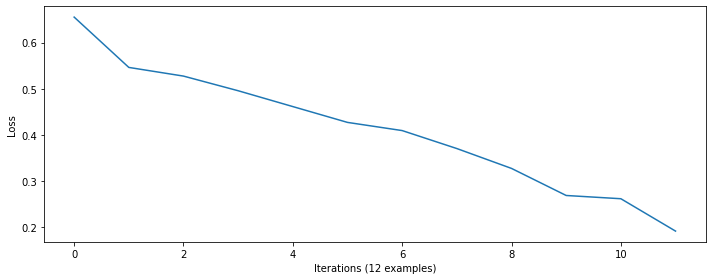

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train_loss)
ax.set_ylabel('Loss')
ax.set_xlabel(f'Iterations ({len(train_loss)} examples)')
fig.tight_layout()
plt.show()

In [19]:
model = model.eval()
test_data = torch.utils.data.DataLoader(dutch_data_converted['test'], batch_size=4)

In [20]:
confusion = torch.zeros(num_labels, num_labels)
found = 0
missed = 0
wrong = 0

for i, batch in enumerate(tqdmn(test_data)):
    if i >= 100:
        break
    with torch.no_grad():
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
            
    s_lengths = batch['attention_mask'].sum(dim=1)
    for idx, length in enumerate(s_lengths):
        true_values = batch['labels'][idx][:length]
        pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
        for true, pred in zip(true_values, pred_values):
            confusion[true.item()][pred.item()] += 1
            if true.item() > 0:
                if pred.item() > 0:
                    found += 1
                else: 
                    missed += 1
            elif pred.item() > 0:
                wrong += 1

In [21]:
if found + wrong == 0:
    precision = 0.0
else:
    precision = found / (found + wrong)
recall = found / (found + missed)

print(f"precision: {precision}; recall: {recall}")

precision: 0.0; recall: 0.0


In [22]:
for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

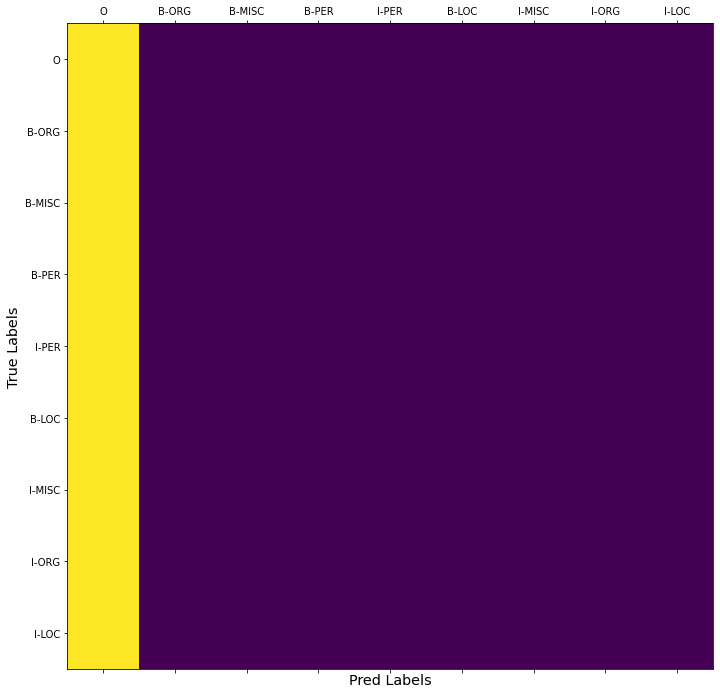

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confusion.numpy())

labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

ax.set_xticks(ids)
ax.set_xticklabels(labels)

ax.set_yticks(ids)
ax.set_yticklabels(labels)

fig.tight_layout()
plt.show()

In [24]:
confusion.numpy()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [25]:
ner_tag_ids

{'O': 0,
 'B-ORG': 1,
 'B-MISC': 2,
 'B-PER': 3,
 'I-PER': 4,
 'B-LOC': 5,
 'I-MISC': 6,
 'I-ORG': 7,
 'I-LOC': 8}

## 2. SemEval-2016 Task 6¶

Source: https://alt.qcri.org/semeval2016/task6/

In [10]:
import os
import pandas as pd
import re

In [2]:
train_data = pd.read_csv("../data/StanceDataset/train_with_newlines.csv", encoding="latin1")

In [3]:
train_data

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos
...,...,...,...,...,...
2909,"There's a law protecting unborn eagles, but no...",Legalization of Abortion,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
2910,I am 1 in 3... I have had an abortion #Abortio...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,other
2911,How dare you say my sexual preference is a cho...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
2912,"Equal rights for those 'born that way', no rig...",Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [4]:
train_data['Target'].value_counts()

Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64

In [5]:
train_data['Stance'].value_counts()

AGAINST    1395
NONE        766
FAVOR       753
Name: Stance, dtype: int64

In [13]:
DATA_DIR = "semeval-2016/"

In [17]:
for text_id in range(0, len(train_data)):
    stance = re.sub(" ", "_", train_data.iloc[text_id]['Stance']).lower()
    target = re.sub(" ", "_", train_data.iloc[text_id]['Target']).lower()
    if not os.path.exists(DATA_DIR + "/stance/" + stance):
        os.mkdir(DATA_DIR + "/stance/" + stance)
    if not os.path.exists(DATA_DIR + "/target/" + target):
        os.mkdir(DATA_DIR + "/target/" + target)
    data_file_stance = open(DATA_DIR + "/stance/" + stance + "/" + str(text_id) + ".txt", "w")
    data_file_target = open(DATA_DIR + "/target/" + target + "/" + str(text_id) + ".txt", "w")
    print(train_data.iloc[text_id]['Tweet'], file=data_file_stance)
    print(train_data.iloc[text_id]['Tweet'], file=data_file_target)
    data_file_target.close()
    data_file_stance.close()

Next: text classification, see: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

## 3. BERT Fine-Tuning Tutorial with PyTorch

Python code source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

(re-instated from earlier version: 20210730)

In [41]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, BertTokenizer, BertForSequenceClassification
import torch
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import get_linear_schedule_with_warmup
import time
import datetime
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import numpy as np
import random
import numpy as np
import time

In [31]:
#DATA_DIR = "social_distancing"
#LABEL_VALUES = {'ANDERS': 0, 'EENS': 1, 'ONEENS': 2}
DATA_DIR = "semeval-2016/stance"
NBR_OF_EPOCHS = 2

In [2]:
def read_text_file(file_name):
    text_file = open(file_name, "r")
    text = ""
    for line in text_file.read():
        text += line
    text_file.close()
    return text


def read_data(data_dir, label_values):
    data = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if label not in label_values:
            label_values[label] = len(label_values)
        for id_file_name in os.listdir(label_dir):
            data.append({"text": read_text_file(os.path.join(label_dir, id_file_name)),
                         "label": label_values[label],
                         "id": re.sub(".txt$", "", id_file_name) })
    data = sorted(data, key=lambda item: item["id"])
    return [ data, label_values ]

In [3]:
data, label_values = read_data(DATA_DIR, {})
sentences = [ item["text"] for item in data ]
file_labels = [ item["label"] for item in data ]

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [5]:
def remove_initial_words(sentence, n):
    words = sentence.strip().split()
    return " ".join(words[int(n):])

In [6]:
def make_input_ids(sentences, file_labels, keep_short_only=False):
    input_ids, attention_masks, expanded_labels, sentence_sources = [], [], [], []
    max_length = 64
    for i in range(0, len(sentences)):
        sentence = sentences[i]
        while len(sentence) > 0:
            encoded_dict = tokenizer.encode_plus(
                                sentence,
                                max_length = max_length,
                                truncation=True,
                                padding='max_length',
                                add_special_tokens = True,
                                return_attention_mask = True,
                                return_tensors = 'pt',
                           )
            if keep_short_only and encoded_dict['attention_mask'][0][max_length-1] != 0:
                break
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
            expanded_labels.append(file_labels[i])
            sentence_sources.append(i)
            sentence = remove_initial_words(sentence, int(max_length/2))
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(expanded_labels)
    return [input_ids, attention_masks, labels, sentence_sources]

In [7]:
def keep_short_sentences(input_ids, sentence_sources):
    short_input_ids = []
    for i in range(0, len(sentence_sources)):
        if (i == 0 or sentence_sources[i] != sentence_sources[i-1]) and (i == len(sentence_sources)-1 or sentence_sources[i] != sentence_sources[i+1]):
            short_input_ids.append(input_ids[i])
    return torch.cat(short_input_ids, dim=0)

The validation include long sentences which are split in different parts (for social distancing data: 597 -> 867). The training data only contain sentences which fit in BERT's phrase space (5380 -> 3638).

In [8]:
def make_data(fold, sentences):
    validation_start = int(0.1 * fold * len(sentences))
    validation_end = int(0.1 * (fold + 1) * len(sentences))
    input_ids, attention_masks, labels, sentence_sources_validation = make_input_ids(sentences[validation_start:validation_end], 
                                                                                     file_labels[validation_start:validation_end], 
                                                                                     keep_short_only=False)
    val_dataset = TensorDataset(input_ids, attention_masks, labels)
    if fold == 0:
        training_sentences = []
        training_file_labels = []
    else:
        training_sentences = sentences[:validation_start]
        training_file_labels = file_labels[:validation_start]
    if fold < 9:
        training_sentences.extend(sentences[validation_end:])
        training_file_labels.extend(file_labels[validation_end:])
    input_ids, attention_masks, labels, _ = make_input_ids(training_sentences, training_file_labels, keep_short_only=True)
    train_dataset = TensorDataset(input_ids, attention_masks, labels)
    return [ train_dataset, val_dataset, sentence_sources_validation ]

In [9]:
def make_experiment(fold, sentences):
    train_dataset, val_dataset, sentence_sources_validation = make_data(fold, sentences)
    print(f"fold: {fold}; train size: {len(train_dataset)}; validation size: {len(val_dataset)}")
    batch_size = 32
    train_dataloader = DataLoader(
                train_dataset,
                sampler = RandomSampler(train_dataset),
                batch_size = batch_size
            )
    validation_dataloader = DataLoader(
                val_dataset,
                sampler = SequentialSampler(val_dataset),
                batch_size = batch_size
            )
    optimizer = AdamW(model.parameters(),
                      lr = 2e-5,
                      eps = 1e-8
                    )
    epochs = NBR_OF_EPOCHS
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0,
                                                num_training_steps = total_steps)
    return [ train_dataset, val_dataset, train_dataloader, validation_dataloader, batch_size, epochs, total_steps, optimizer, scheduler, sentence_sources_validation ]

In [10]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [11]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [12]:
def get_prediction_labels(predictions):
    prediction_labels = []
    for i in range(len(predictions)):
        prediction_labels.extend(np.argmax(predictions[i], axis=1).flatten())
    return prediction_labels

In [13]:
def collapse_labels(true_labels, predictions, sentence_sources, label_values):
    prediction_labels = get_prediction_labels(predictions)
    true_labels_flattened = []
    for array in true_labels:
         true_labels_flattened.extend(array)
    prediction_labels_collapsed = []
    true_labels_collapsed = []
    for i in range(0, len(sentence_sources)):
        if i == 0 or sentence_sources[i] != sentence_sources[i-1]:
            prediction_labels_collapsed.append(prediction_labels[i])
            true_labels_collapsed.append(true_labels_flattened[i])
        elif prediction_labels[i] != label_values['ANDERS']:
            prediction_labels_collapsed[-1] = prediction_labels[i]
    return [ true_labels_collapsed, prediction_labels_collapsed ]

In [14]:
def train_model(model, train_dataloader, device, optimizer, scheduler):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}    Loss: {:.3f}.'.format(step, len(train_dataloader), elapsed, total_train_loss/step))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].long().to(device)
        model.zero_grad()        
        model_output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = model_output["loss"]
        logits = model_output["logits"]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    return avg_train_loss, training_time

In [15]:
def validate_model(model, validation_dataloader, device, sentence_sources_validation, label_values):
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    logits_total, label_ids_total = [], []
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            model_output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = model_output["loss"]
        logits = model_output["logits"]
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        logits_total.append(logits)
        label_ids_total.append(label_ids)
    true_labels_collapsed, prediction_labels_collapsed = collapse_labels(label_ids_total, logits_total, sentence_sources_validation, label_values)
    print(confusion_matrix(true_labels_collapsed, prediction_labels_collapsed))
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.3f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.3f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    return [ avg_val_accuracy, avg_val_loss, validation_time, true_labels_collapsed, prediction_labels_collapsed ]

In [32]:
true_labels = []
predicted_labels = []
for fold in range(0, 1):
    model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base", num_labels = len(label_values))
    train_dataset, val_dataset, train_dataloader, validation_dataloader, batch_size, epochs, total_steps, optimizer, scheduler, sentence_sources_validation = \
        make_experiment(fold, sentences)
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    if torch.cuda.is_available():
         torch.cuda.manual_seed_all(seed_val)
    training_stats = []
    total_t0 = time.time()

    device = torch.device("cpu")
    print(f"======== Fold {fold:2d} ============")
    for epoch_i in range(0, epochs):
        avg_train_loss, training_time = train_model(model, train_dataloader, device, optimizer, scheduler)
        avg_val_accuracy, avg_val_loss, validation_time, true_labels_collapsed, prediction_labels_collapsed = \
            validate_model(model, validation_dataloader, device, sentence_sources_validation, label_values)
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    true_labels.extend(true_labels_collapsed)
    predicted_labels.extend(prediction_labels_collapsed)
    print("")
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.dense.weight', 'class

fold: 0; train size: 2623; validation size: 291
======== Fold  0 ============
======== Epoch 1 / 2 ========
Training...
  Batch    10  of     82.    Elapsed: 0:02:06    Loss: 1.051.
  Batch    20  of     82.    Elapsed: 0:03:40    Loss: 1.068.
  Batch    30  of     82.    Elapsed: 0:05:20    Loss: 1.057.
  Batch    40  of     82.    Elapsed: 0:07:12    Loss: 1.064.
  Batch    50  of     82.    Elapsed: 0:08:51    Loss: 1.061.
  Batch    60  of     82.    Elapsed: 0:10:25    Loss: 1.052.
  Batch    70  of     82.    Elapsed: 0:12:03    Loss: 1.046.
  Batch    80  of     82.    Elapsed: 0:13:41    Loss: 1.050.

  Average training loss: 1.050
  Training epoch took: 0:14:01

Running Validation...
[[ 86   0   0]
 [ 63   0   0]
 [139   3   0]]
  Accuracy: 0.269
  Validation Loss: 1.234
  Validation took: 0:00:28
======== Epoch 2 / 2 ========
Training...
  Batch    10  of     82.    Elapsed: 0:01:39    Loss: 1.003.
  Batch    20  of     82.    Elapsed: 0:03:59    Loss: 1.018.
  Batch    30  o

In [33]:
confusion_matrix(true_labels, predicted_labels)

array([[ 86,   0,   0],
       [ 59,   4,   0],
       [137,   5,   0]])

In [34]:
def get_accuracy(cm):
    correct = 0
    wrong = 0
    for i in range(0, len(cm)):
        for j in range(0, len(cm)):
            if i == j:
                correct += cm[i][j]
            else:
                wrong += cm[i][j]
    return correct/(correct+wrong)

In [35]:
get_accuracy(confusion_matrix(true_labels, predicted_labels))

0.30927835051546393

In [36]:
def training_overview(training_stats):
    pd.set_option('precision', 2)
    df_stats = pd.DataFrame(data=training_stats)
    df_stats = df_stats.set_index('epoch')
    return df_stats

In [37]:
def training_graph(df_stats):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (6,4)
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks()
    plt.show()

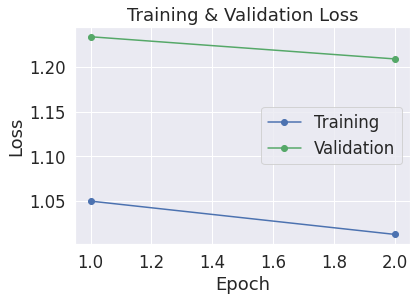

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.05,1.23,0.27,0:14:01,0:00:28
2,1.01,1.21,0.28,0:20:23,0:00:26


In [38]:
df_stats = training_overview(training_stats)
training_graph(df_stats)
df_stats

In [39]:
def process_test_data(test_dataloader, test_dataset):
    print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))
    model.eval()
    predictions , true_labels = [], []
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(logits)
        true_labels.append(label_ids)
    print('    DONE.')
    return [ true_labels, predictions ]

In [40]:
def show_evaluation_results(true_labels, predictions):
    prediction_labels = get_prediction_labels(predictions)
    true_labels_flattened = []
    for array in true_labels:
         true_labels_flattened.extend(array)
    print(label_values)
    return confusion_matrix(true_labels_flattened, prediction_labels)

In [44]:
start_time = time.time()
true_labels, predictions = process_test_data(validation_dataloader, val_dataset)
print(f"running time: {int(time.time() - start_time)} seconds")

Predicting labels for 291 test sentences...
    DONE.
running time: 24 seconds


In [45]:
true_labels_collapsed, predictions_collapsed = collapse_labels(true_labels, predictions, sentence_sources_validation, label_values)

In [46]:
cm = confusion_matrix(true_labels_collapsed, predictions_collapsed)
print(f"accuracy: {get_accuracy(cm):.3f}")
print(cm)

accuracy: 0.309
[[ 86   0   0]
 [ 59   4   0]
 [137   5   0]]


In [47]:
total_list = []
for x in true_labels:
    total_list.extend(x)
len(total_list)

291

In [48]:
len(predicted_labels)

291

In [49]:
label_values

{'against': 0, 'none': 1, 'favor': 2}

In [56]:
pd.array(predicted_labels).value_counts()

0    282
1      9
dtype: Int64

In [59]:
len(sentences)

2914

In [71]:
def show_ids(string):
    for i in range(0,len(sentences)):
        if re.search(string, sentences[i],re.IGNORECASE):
            print(i, end=" ")

In [72]:
show_ids("abortion")

207 350 351 352 642 719 1462 1473 1474 1477 1479 1482 1484 1486 1489 1492 1497 1534 1536 1545 1563 1571 1577 1596 1599 1601 1612 1616 1618 1619 1628 1629 1630 1634 1636 1641 1647 1648 1649 1655 1661 1663 1679 1682 1683 1684 1719 1725 1726 1741 1765 1767 1773 1774 1775 1776 1778 1792 1793 1803 1815 1817 1820 1830 1834 1853 1870 1878 1882 1899 1901 1915 1923 1926 1940 1952 1966 1975 1985 1986 1987 1992 1994 1998 2000 2005 2007 2018 2020 2021 2022 2025 2026 2028 2043 2044 2047 2051 2052 2059 2062 2064 2065 2066 2067 2071 2074 2078 2081 2096 2107 2111 2118 2119 2121 2125 2360 2437 2448 2504 2559 2570 2582 2615 2759 

In [73]:
show_ids("clinton")

2 113 224 446 752 754 755 758 759 770 781 783 784 787 789 796 797 798 803 811 818 819 822 832 839 840 842 847 851 852 854 861 862 863 869 870 871 875 878 880 882 884 887 888 889 892 894 897 899 901 903 904 908 909 915 916 920 921 922 923 925 928 930 931 937 938 942 943 945 948 953 956 964 972 975 986 989 992 993 994 995 1000 1004 1006 1007 1011 1014 1015 1016 1018 1019 1028 1032 1033 1036 1040 1045 1058 1062 1071 1073 1085 1086 1094 1095 1096 1097 1098 1099 1107 1110 1113 1118 1121 1124 1127 1128 1131 1134 1137 1144 1149 1152 1154 1155 1156 1161 1167 1178 1181 1184 1186 1189 1194 1195 1198 1199 1205 1207 1208 1215 1217 1218 1220 1221 1226 1228 1232 1233 1241 1253 1254 1262 1264 1268 1272 1281 1283 1286 1287 1288 1295 1296 1298 1304 1309 1311 1316 1321 1330 1333 1339 1348 1352 1357 1360 1361 1362 1363 1364 1366 1367 1368 1371 1372 1374 1375 1376 1377 1379 1395 1400 1401 1404 1405 1410 1412 1414 1421 1422 1427 1428 1431 1438 1439 1441 1446 1457 1461 1493 1543 1651 1659 1668 1681 2138 217